# Data Exploration Notebook

As part of any predictive modeling, we need to have a deeper understanding of the dataset as provided. In this notebook we will dissect the independent and dependent variables for the given dataset. With a better understanding of the different columns we hope to able to select the right features to help our model deliver stellar predictions

## Library and Function Imports

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)

import json
import numpy as np
from shapely.geometry import Point, shape, LineString, Polygon
import folium
import matplotlib.pyplot as plt


import io
from PIL import Image


Tanzania_coord = (-6.3690,34.8888) # The coordinates of Tanzania per Google maps

In [6]:
from src.pandas_helper import colInfo

## Loading the Data

In [7]:
X_train_raw = pd.read_csv('data/Training_set.csv')
y_train_raw = pd.read_csv('data/Training_labels.csv')

X_test_raw = pd.read_csv('data/Test_set.csv')

df_train = pd.merge(X_train_raw,y_train_raw,on='id')

Lets have a quick look over our dataframe

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
df_train.select_dtypes(np.number).shape[1]

10

There are 40 columns in this dataset, 39 features to every predictive label.
There are 10 numerical columns with the rest being comprised of strings. 

In [10]:
df_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Quite a few columns have missing values. Scheme_name immediately sticks out with nearly half of its values missing.

# Column Analysis

Ok. Lets take a deeper dive into each column.

We shall be employing a helper function to help us visualize and summarize the data.

### ID

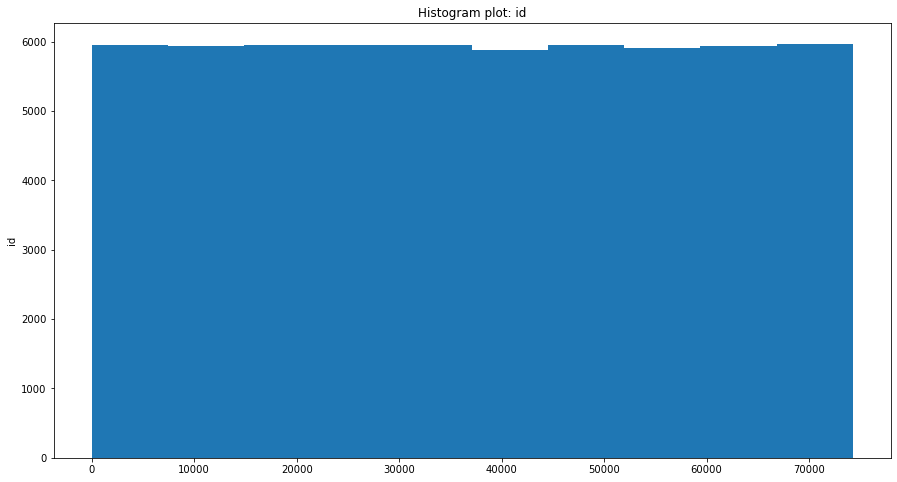

In [11]:
colInfo(df_train.id)

ID is a unique identifier to every recorded well site. It has no predictive ability and will not inform our model in any meaningful way.

### amount_tsh

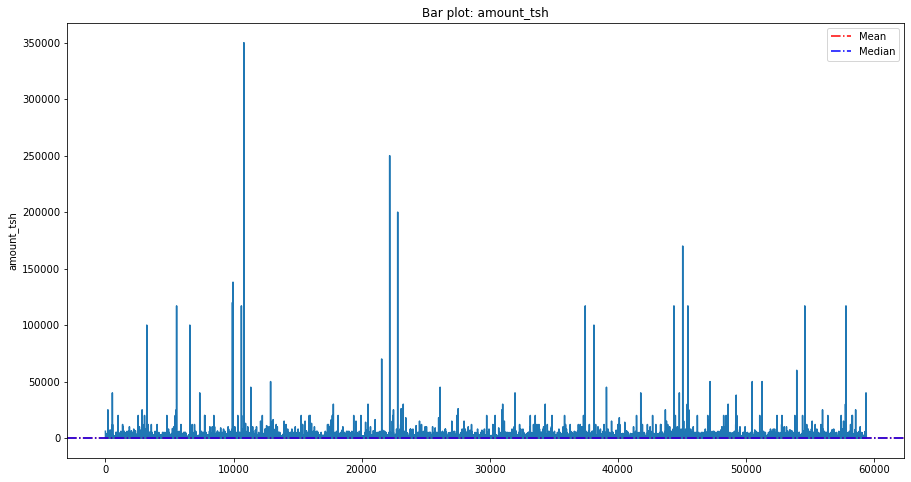

In [12]:
colInfo(df_train.amount_tsh)

In [13]:
df_train.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

The amount_tsh column describes the total static head associated for the well water site. In layman's terms it is the difference in height from the inlet of a pump system compared to the discharge. For a more accurate measurement pressures on both end have to be accounted, but assuming that there is no additional pressures, this gives an indication of how high a pump system will have to lift the water.

In general these values are almost always positive with the discharge generally being above the inlet. The fact that 70% of this column is filled with zeroes makes me think that 0 is a confounding value. They are either genuinely zero or were used as a placeholder for 'N/A' or 'unknown'.

Either way, with 70% of the data being zero, this column is heavily skewed. This is further emphasized with the column having mean value of 317.6, a median of 0 and a max of 350,000.

I do not think that this column can inform the model very well.

### funder

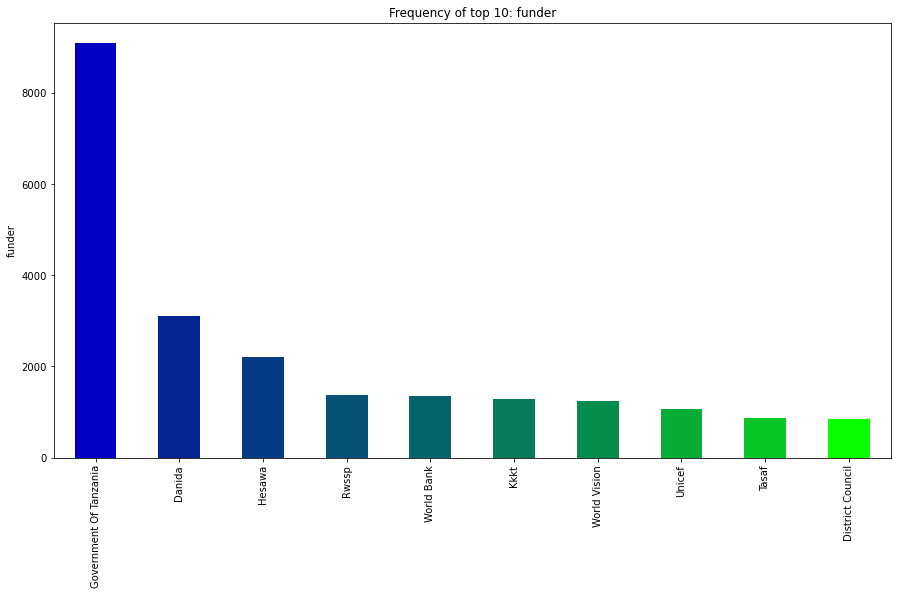

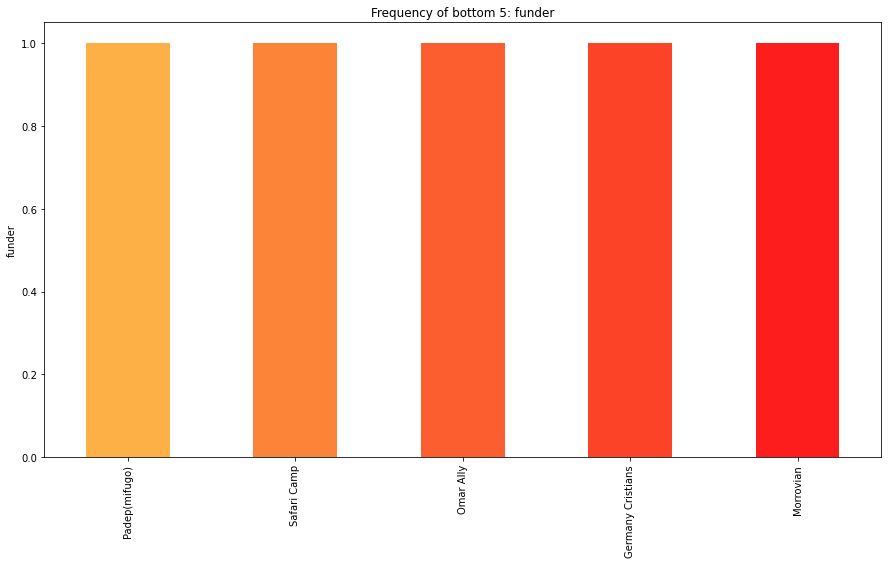

In [14]:
colInfo(df_train.funder)

This column is missing 6% of its data, which is not insurmountable. However, this column is also very varied. 

Looking at the value count table showing the top 10 funders by well site count, from 7th position onwards no funder occupies more than 2% of the dataset.

There are 1897 unique funders working in the country. As a categorical column, it will have the similar effect as 'id' as a predictor. It is too unique and granular a predictor. 

### gps_height

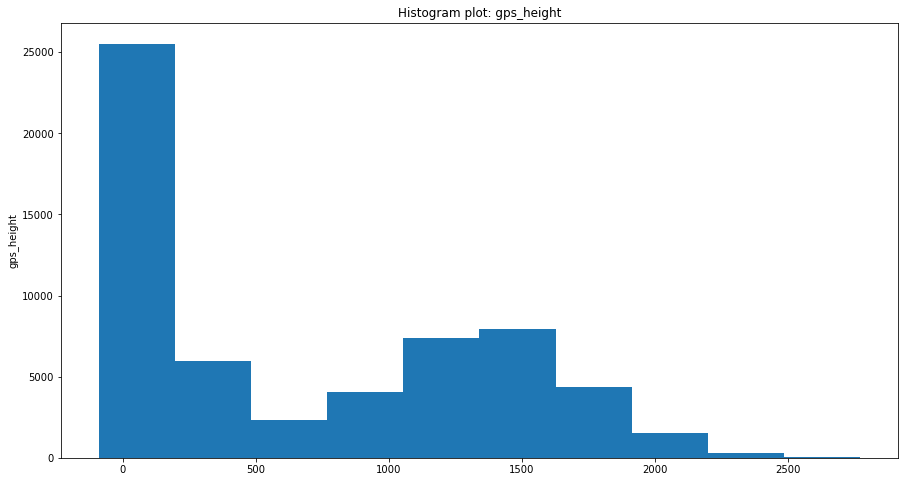

In [15]:
colInfo(df_train.gps_height)

In [16]:
(df_train.gps_height<0).sum()/df_train.shape[0]

0.025185185185185185

This column shows the height of the well water site compared to sea level. 

Looking at the the data readout, we see that the data in this has high number of zeroes. 34%, in fact. The distribution is not normal around zero either, with only 2.5% of the entire column being in the negative.

I believe this to be a confounding variable as well, with us unable to ascertain, whether the site is genuinely at sea level or has been mis-recorded. 

### installer

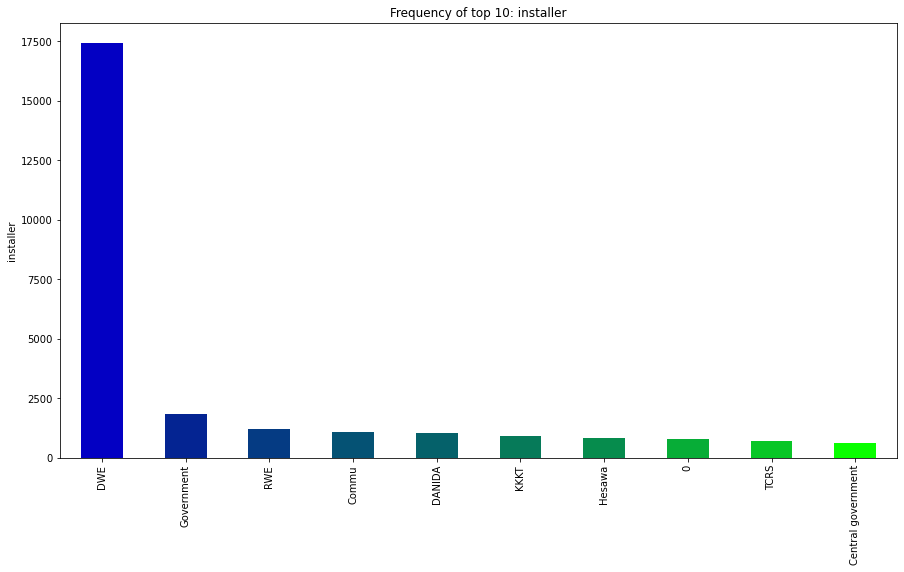

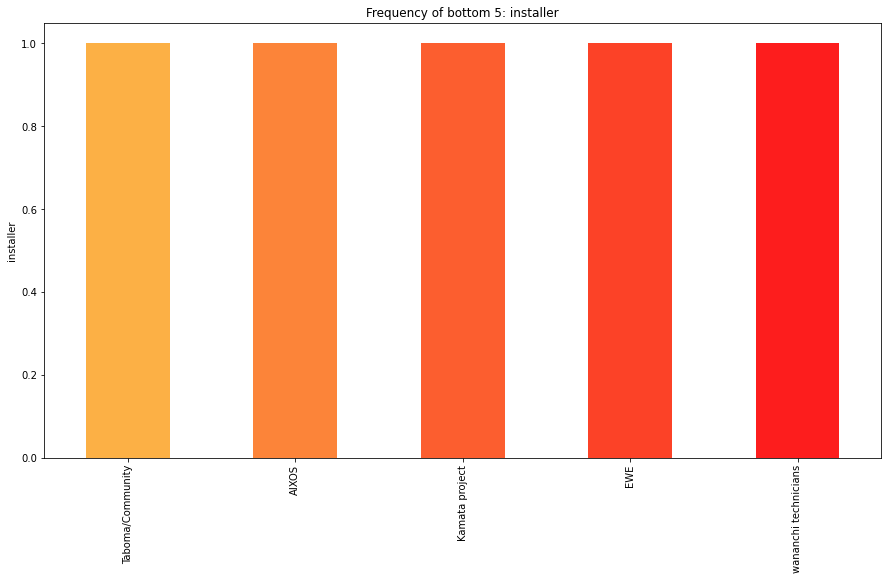

In [17]:
colInfo(df_train.installer)

Similar to the funders column, this column has some missing data that can be overcome, there are 2,146 installers and runs into the same issue as funders. It is too unique and is a bad predictor.

### latitude & longitude

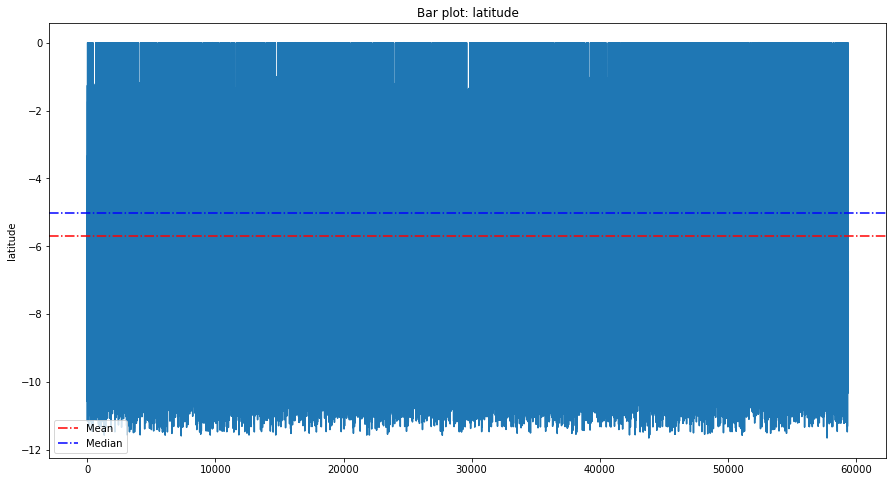

In [18]:
colInfo(df_train.latitude)

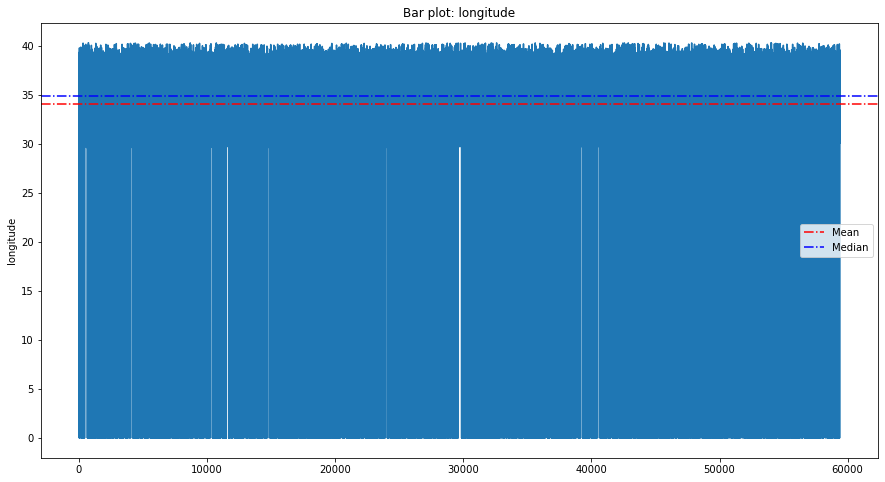

In [19]:
colInfo(df_train.longitude)

What immediately sticks out are the 1,812 sites that share the same latitudes and the 1,812 sites that share the same longitude. Lets see if they are all associated with the same (latitude, longitude) tuple

In [20]:
df_train[['latitude','longitude']].value_counts().head(3)

latitude       longitude
-2.000000e-08  0.000000     1812
-6.975594e+00  39.105307       2
-6.978755e+00  39.093095       2
dtype: int64

In [21]:
df_train[['latitude','longitude']].value_counts(normalize=True).head(3)

latitude       longitude
-2.000000e-08  0.000000     0.030505
-6.975594e+00  39.105307    0.000034
-6.978755e+00  39.093095    0.000034
dtype: float64

All 1,812 sites (3% of our dataset) are recorded as being on the same GPS coordinates. Some overlap do occur but notice that the second highest count of a give pair of latitude and longitude is 2 sites.
Lets look at map and mark this location.

In [22]:
# Plotting (0,-2e-08) on the map to get a geospatial understanding
m=folium.Map(location=Tanzania_coord, zoom_start=4, tiles='CartoDB positron')

with open('data/stanford-gn214np6763-geojson_nationalBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

geo_j = folium.GeoJson(data=geoJSON_raw,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)


folium.Marker(
    location=(0,-2e-08),
    icon=folium.Icon(color="blue",icon="tint", prefix='fa')
).add_to(m)


#Save the map to an HTML file
m.save('maps/BadCoordinates.html')

m

These sites are recorded to be existing off the west coast of the African subcontinent. Fairly certain these have been recorded in error. Lets look at them in further detail.

In [23]:
df_train.loc[df_train.longitude == 0].region.unique()

array(['Shinyanga', 'Mwanza'], dtype=object)

All 1,812 sites lie within the regions of Shinyanga and Mwanza. Lets look at how the other wells in the region are located. First we shall create a dataframe for each of these locations excluding the erroneous sites.

In [24]:
df_Mwanza_ignore0Long=df_train[df_train.region=='Mwanza'].loc[df_train.longitude>0]
df_Mwanza_ignore0Long[['latitude','longitude']].describe()

latitude    longitude
count  2295.000000  2295.000000
mean     -2.620502    33.091564
std       0.329898     0.329287
min      -3.424444    32.046458
25%      -2.847182    32.943112
50%      -2.634751    33.081836
75%      -2.476632    33.345810
max      -1.714486    33.756895

In [25]:
df_Shinyanga_ignore0Long=df_train[df_train.region=='Shinyanga'].loc[df_train.longitude>0]
df_Shinyanga_ignore0Long[['latitude','longitude']].describe()

latitude    longitude
count  3977.000000  3977.000000
mean     -3.495696    33.240121
std       0.328573     0.765545
min      -4.381946    31.454726
25%      -3.768391    32.535525
50%      -3.499209    33.437223
75%      -3.229457    33.860597
max      -2.823028    34.758734

Now using the min and max values of this dataframe we can draw a region that includes all well sites associated with the regions. We can substitute the median of the coordinates for the erroneouq sites. Lets mark these as well on the same map as before to get a geospatial understanding.

In [26]:
m=folium.Map(location=(df_Shinyanga_ignore0Long['latitude'].median(),df_Shinyanga_ignore0Long['longitude'].median()), 
             zoom_start=8, 
             tiles='CartoDB positron')

style = {'fillColor': '#00FFFFFF', 'lineColor': '#00FFFFFF'}

with open('data/stanford-gn214np6763-geojson_nationalBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

geo_j = folium.GeoJson(data=geoJSON_raw,
#                            style_function=lambda x: {'fillColor': 'orange'}
                      style_function=lambda x: style).add_to(m)
geo_j.add_to(m)



# Draw region in which Shinyanga water wells are in the dataset
folium.Rectangle([(df_Mwanza_ignore0Long['latitude'].min(),df_Mwanza_ignore0Long['longitude'].min()), 
                  (df_Mwanza_ignore0Long['latitude'].max(),df_Mwanza_ignore0Long['longitude'].max())],
                fill=True,fill_color='red').add_to(m)

#Dropping a pin of the median lat and median logitude water well
folium.Marker(
        location=(df_Mwanza_ignore0Long['latitude'].median(),df_Mwanza_ignore0Long['longitude'].median()),
        icon=folium.Icon(color="blue",icon="tint", prefix='fa')
    ).add_to(m)

# Draw region in which Mwanza water wells are in the dataset
folium.Rectangle([(df_Shinyanga_ignore0Long['latitude'].min(),df_Shinyanga_ignore0Long['longitude'].min()), 
                  (df_Shinyanga_ignore0Long['latitude'].max(),df_Shinyanga_ignore0Long['longitude'].max())],
                fill=True,fill_color='red').add_to(m)

#Dropping a pin of the median lat and median logitude water well
folium.Marker(
        location=(df_Shinyanga_ignore0Long['latitude'].median(),df_Shinyanga_ignore0Long['longitude'].median()),
        icon=folium.Icon(color="blue",icon="tint", prefix='fa')
    ).add_to(m)


#Save the map to an HTML file
m.save('maps/MwanzaAndShinyanga Relocations.html')

m

This method ought to be good way to account for the incorrect data without having to drop this feature. Location ought to play a strong role in determining a well sites status.

### wpt_name

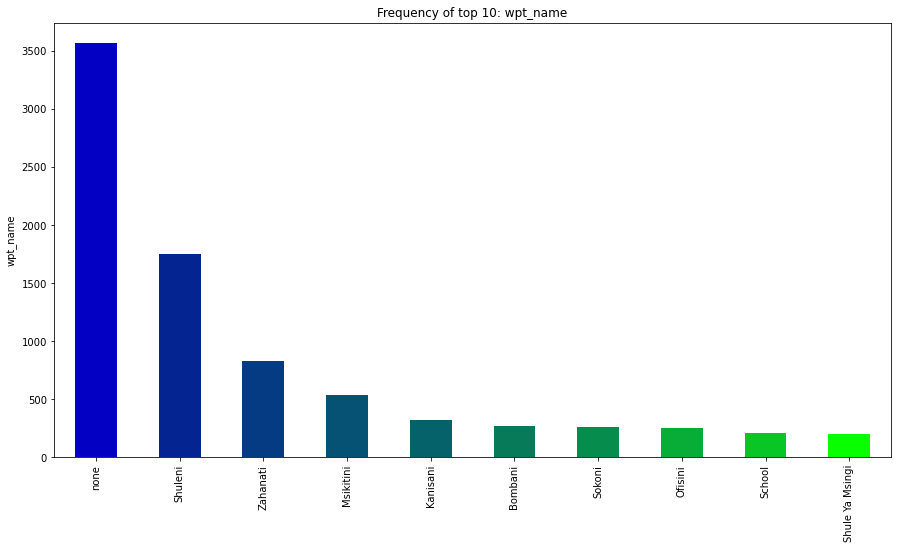

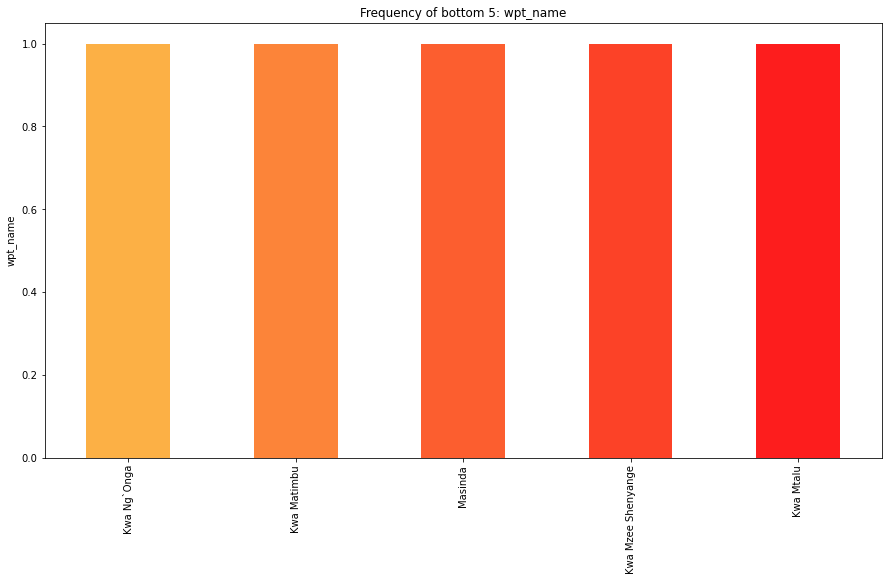

In [27]:
colInfo(df_train.wpt_name)

60% of the data in this column is unique. Highly recommend dropping this column.

### num_private

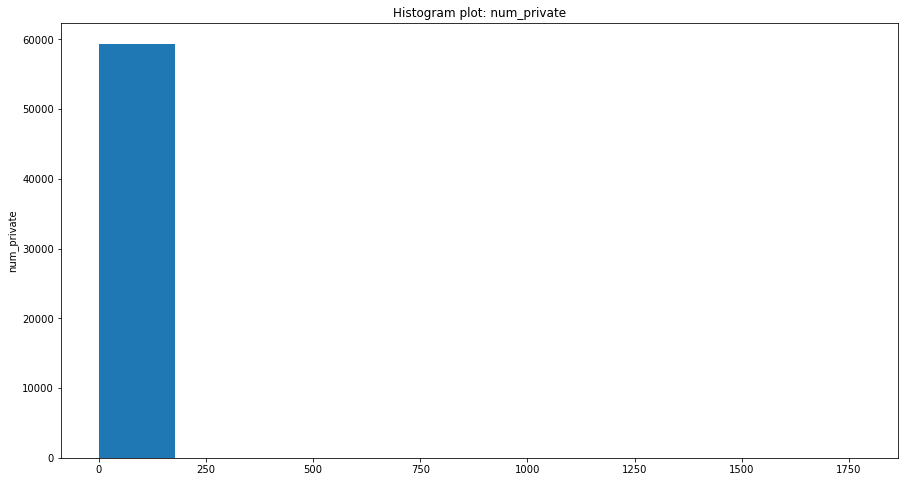

In [28]:
colInfo(df_train.num_private)

This column is heavily skewed. In fact it is 98.7% filled with zeroes. This column has no predictive value.

### basin

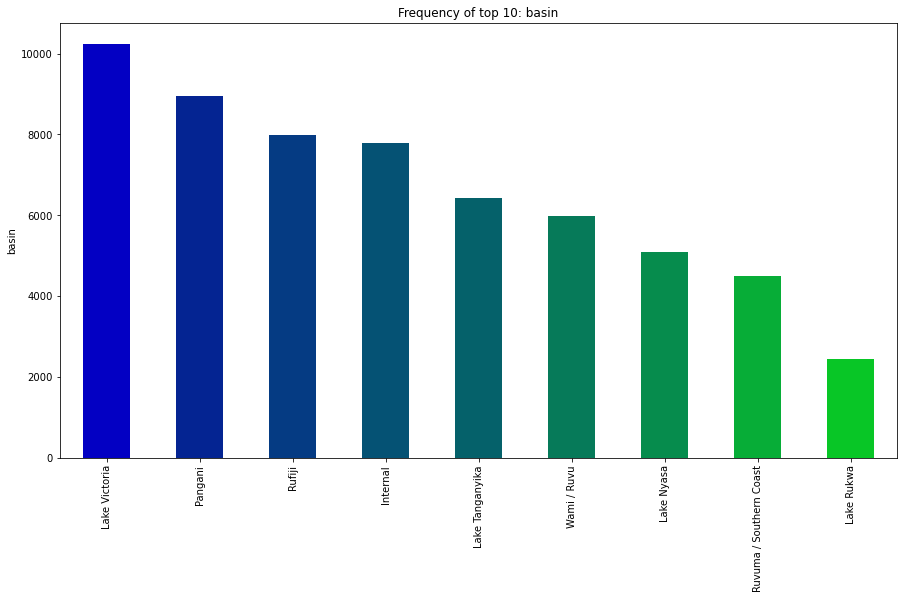

In [29]:
colInfo(df_train.basin)

This column should be a great predictor. It has only 9 unique values and has no zeroes or missing values. This column is prime for One Hot Encoding.

### sub-village

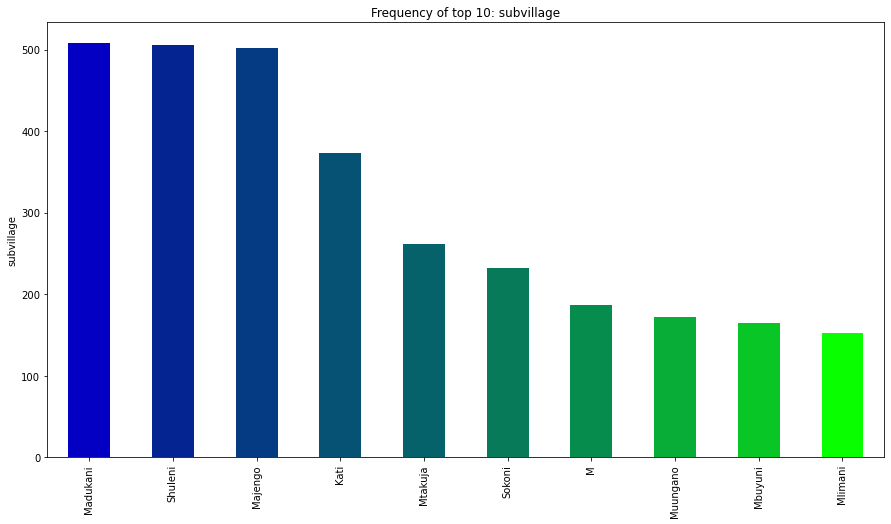

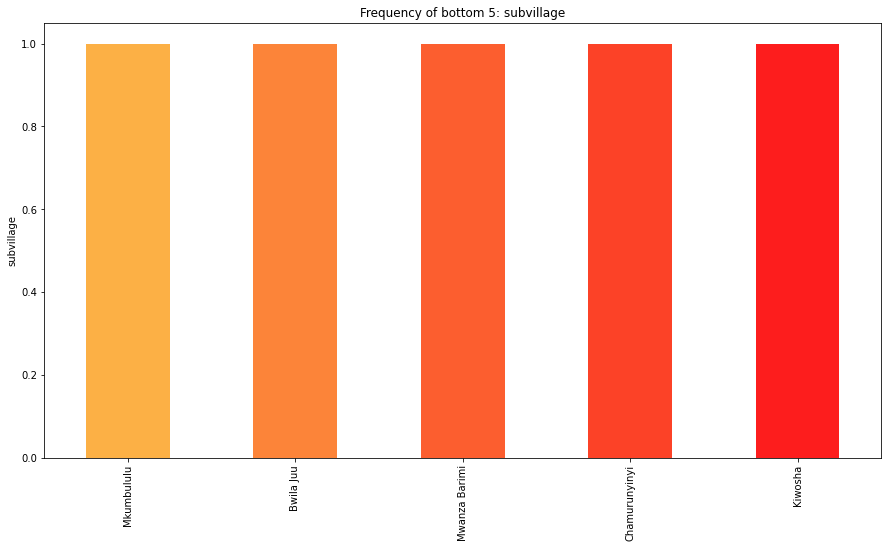

In [30]:
colInfo(df_train.subvillage)

32% of the data in this column is unique with over 19,000 unique values. Highly recommend dropping this column.

### Region & Region Code

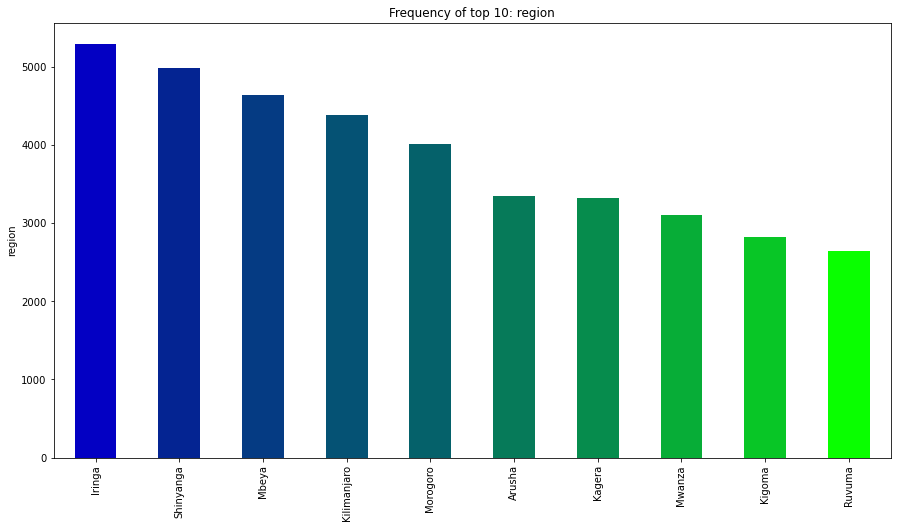

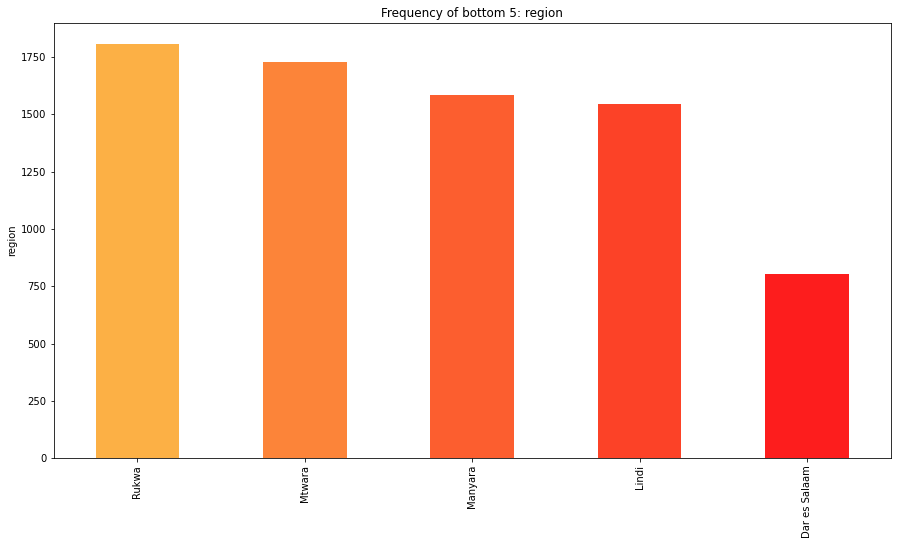

In [31]:
colInfo(df_train.region)

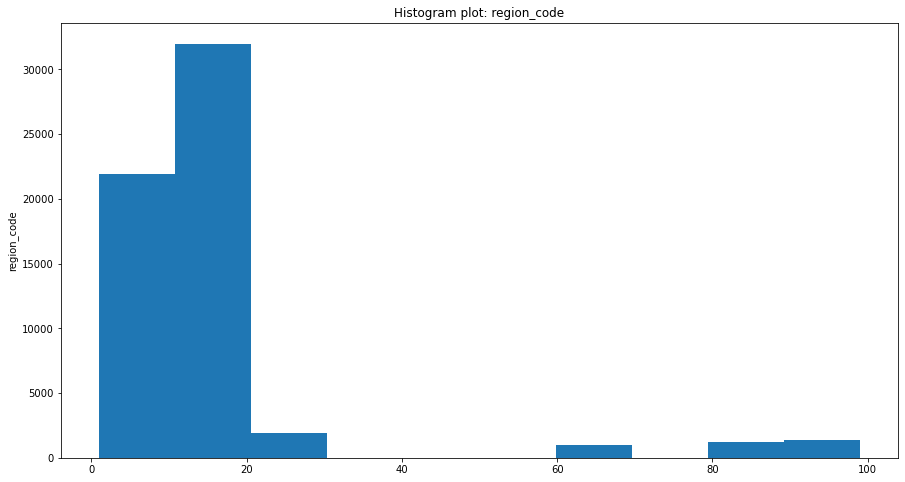

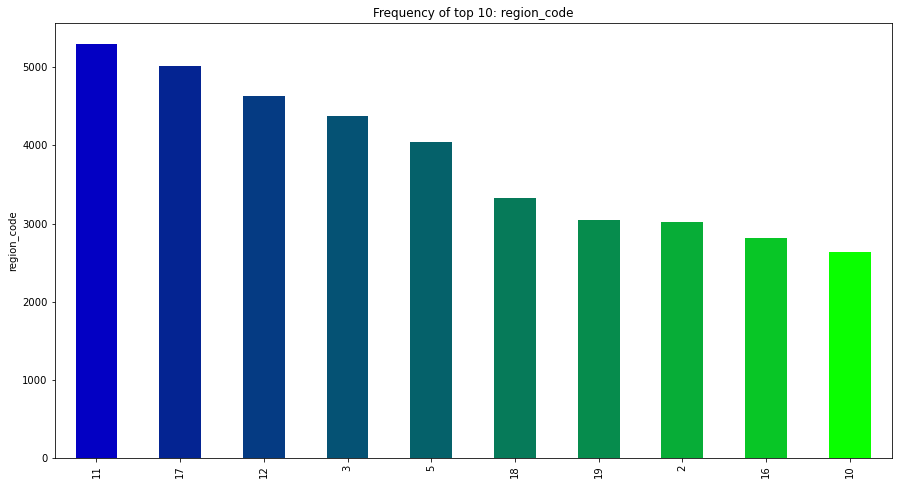

In [32]:
colInfo(df_train.region_code)

These two columns share a lot of similarity.

In [70]:
df_train[['region','region_code']].value_counts()

region         region_code
Iringa         11             5294
Shinyanga      17             4956
Mbeya          12             4639
Kilimanjaro    3              4379
Morogoro       5              4006
Kagera         18             3316
Mwanza         19             3047
Arusha         2              3024
Kigoma         16             2816
Ruvuma         10             2640
Tanga          4              2513
Dodoma         1              2201
Singida        13             2093
Mara           20             1969
Tabora         14             1959
Rukwa          15             1808
Pwani          6              1609
Manyara        21             1583
Lindi          80             1238
Pwani          60             1025
Mtwara         90              917
Dar es Salaam  7               805
Mtwara         99              423
               9               390
Arusha         24              326
Lindi          8               300
Mwanza         17               55
Tanga          5            

In fact they are almost identical. I'd prefer to use the region, as it has fewer unique columns and is more readable. But either one should be fine. Using both will unnaturally weigh these features.

### District Code

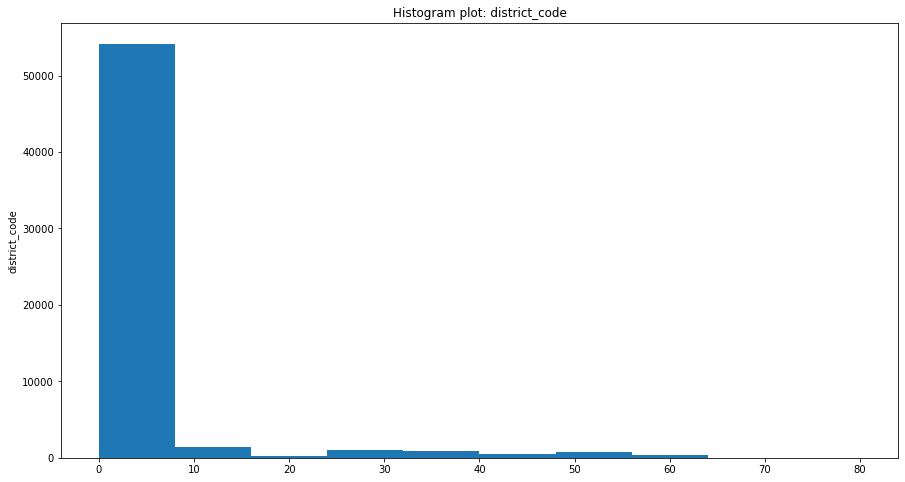

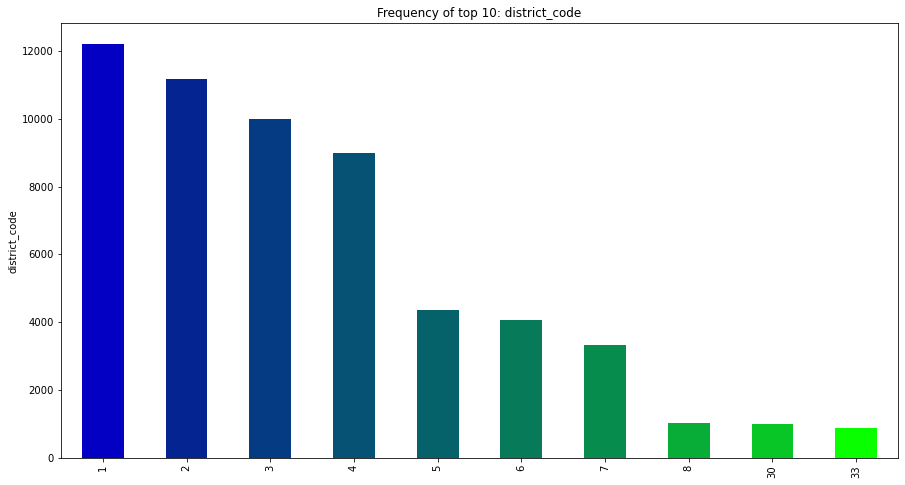

In [33]:
colInfo(df_train.district_code)

This column may be useful, however I expect it to have a strong corelation with the region. Either way regardless of it being a number, it will have to be treated as a categorical.

### lga

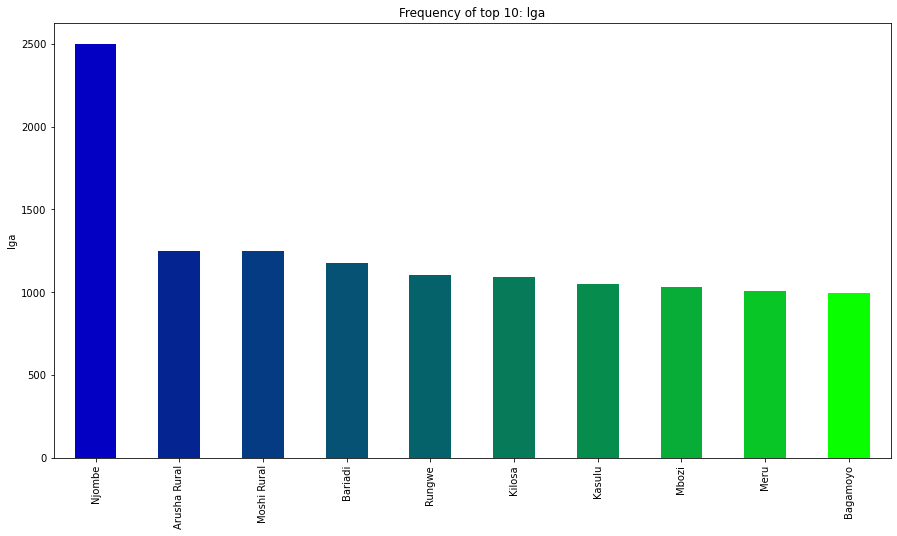

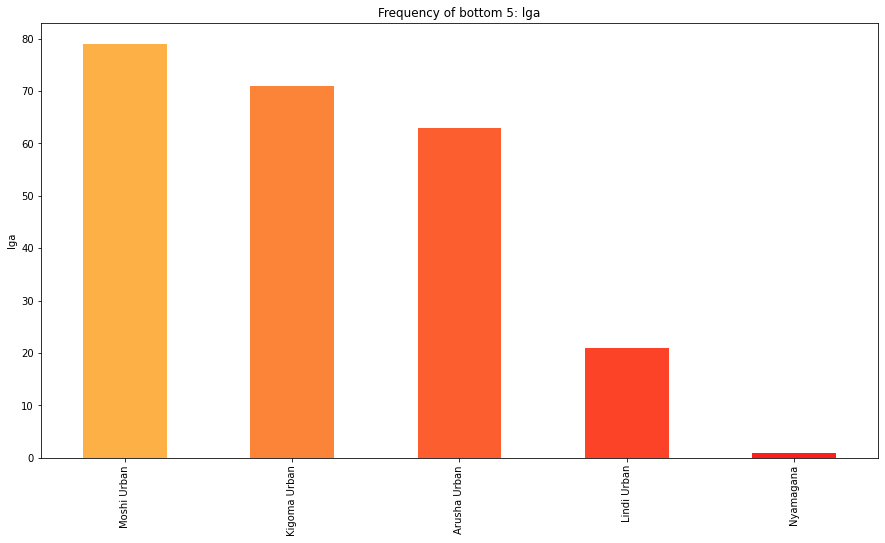

In [34]:
colInfo(df_train.lga)

Sitting with 125 distinct labels, I'd recommend not using this column. It is substantially better than 'funder' or 'installer', it will however come at a high computing expense.

### ward

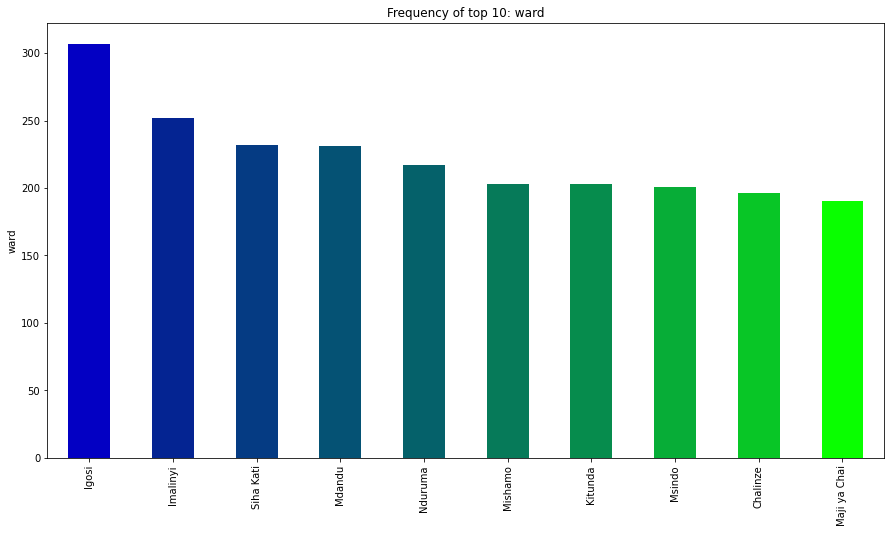

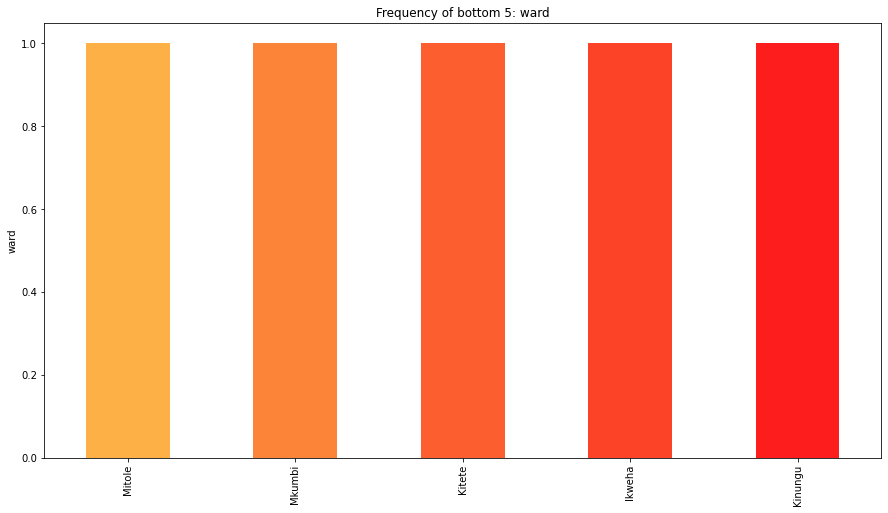

In [35]:
colInfo(df_train.ward)

This column has nearly 3000 unique values. Highly recommend dropping this column

### population

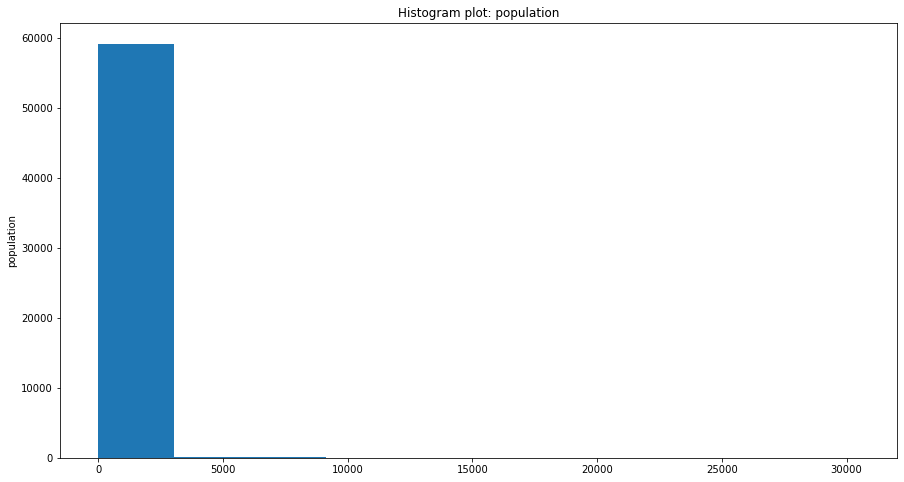

In [36]:
colInfo(df_train.population)

Nearly 36% of well water sites have a population of **0** around it? Find that hard to believe.

In [37]:
df_train.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

<AxesSubplot:>

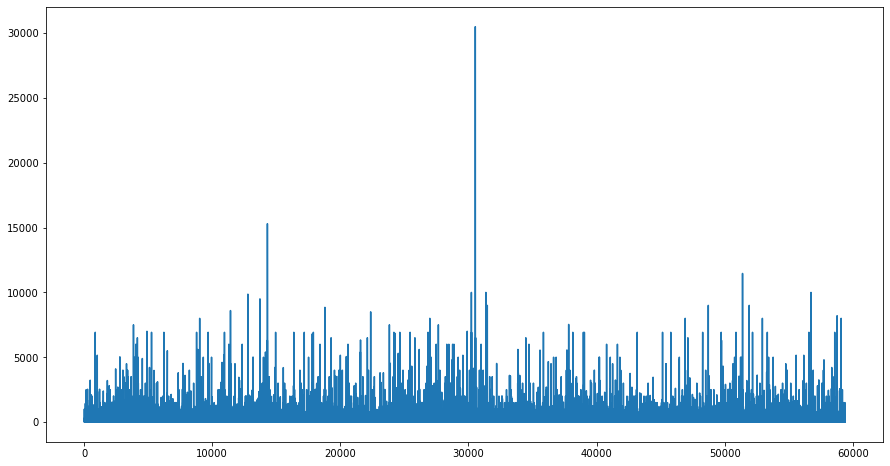

In [38]:
df_train.population.plot(kind='line',figsize=(15,8))

Not comfortable imputing zeroes (which would be a third of our dataset) in this scenario. There is also always a possibility that some wells may not have a population around them. If we are to impute these zeroes with the population median,\
Median = 25\
Number of wells with 0 pop = 21381

In [39]:
25*21381/df_train.population.sum()

0.050017999087272697

We'd be increasing the overall population of the entire dataset by 5%. Highly recommend dropping it.

### public_meeting

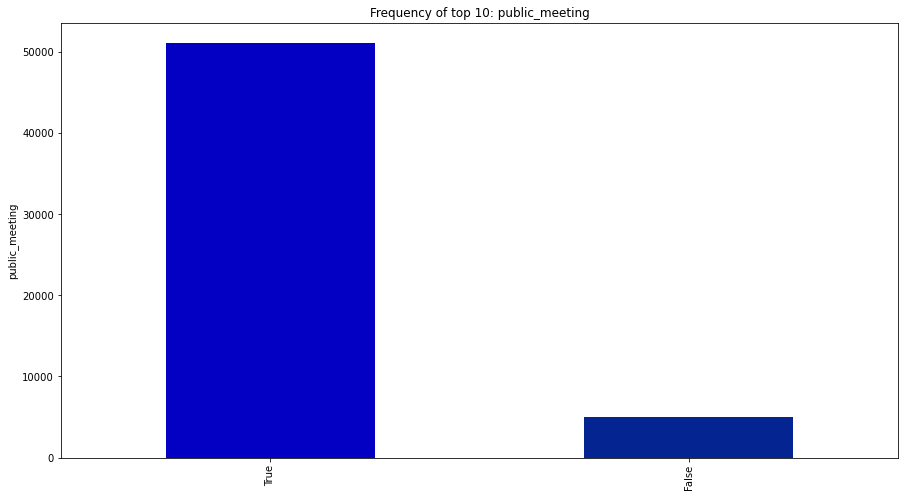

In [40]:
colInfo(df_train.public_meeting)

This column has about 5% of missing values which we can impute. It otherwise a very viable column.

### scheme_management

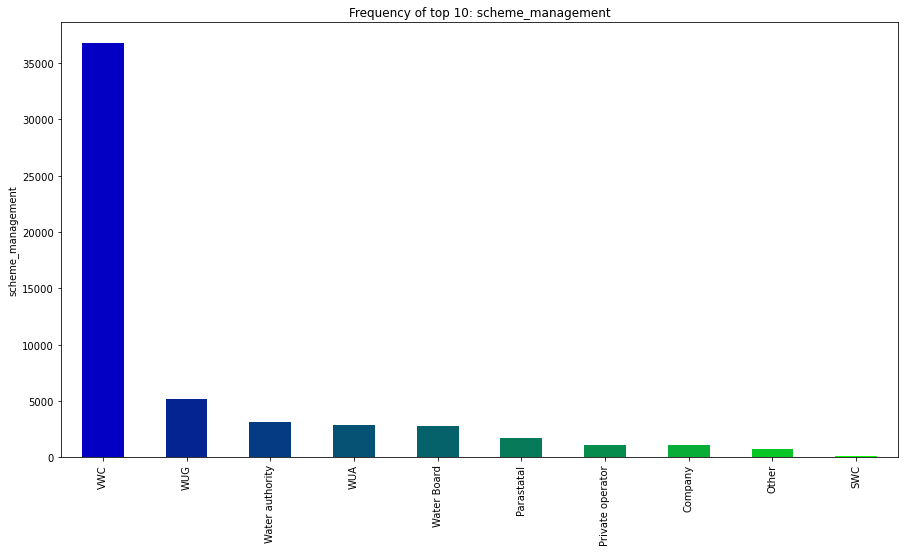

In [41]:
colInfo(df_train.scheme_management)

This column has 6.5% data missing which we should be able to impute. This is however a heavily skewed column with 66% of the column being 'WWC'. Recommend using with caution.

### scheme_name

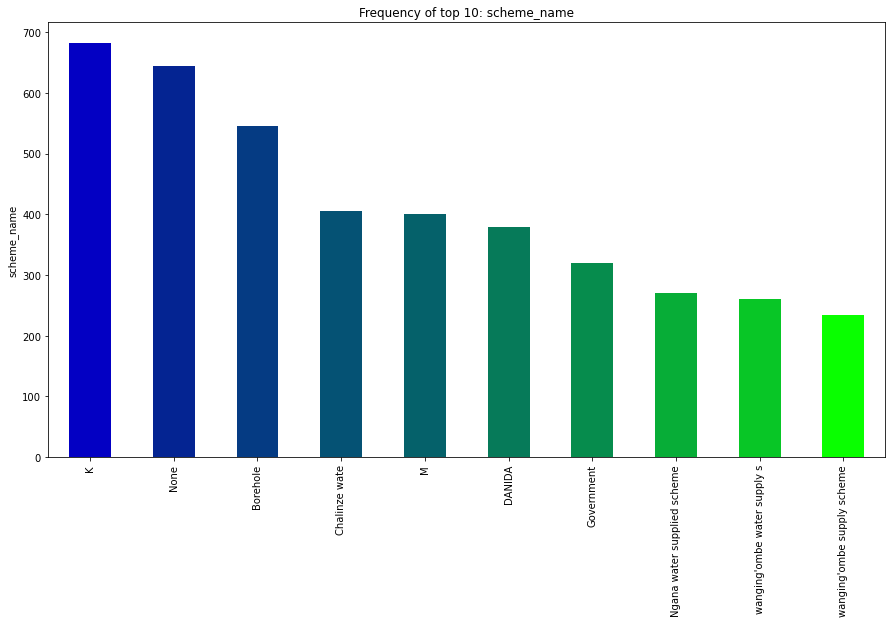

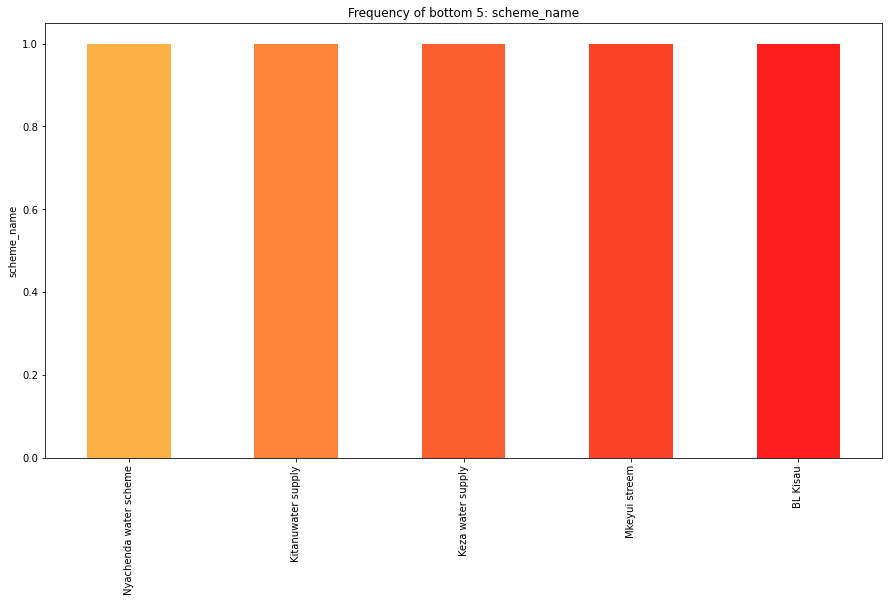

In [42]:
colInfo(df_train.scheme_name)

Nearly half the data in this column is missing, and of the remainder there are nearly 2,700 unique values. Highly recommend dropping this column.

### permit

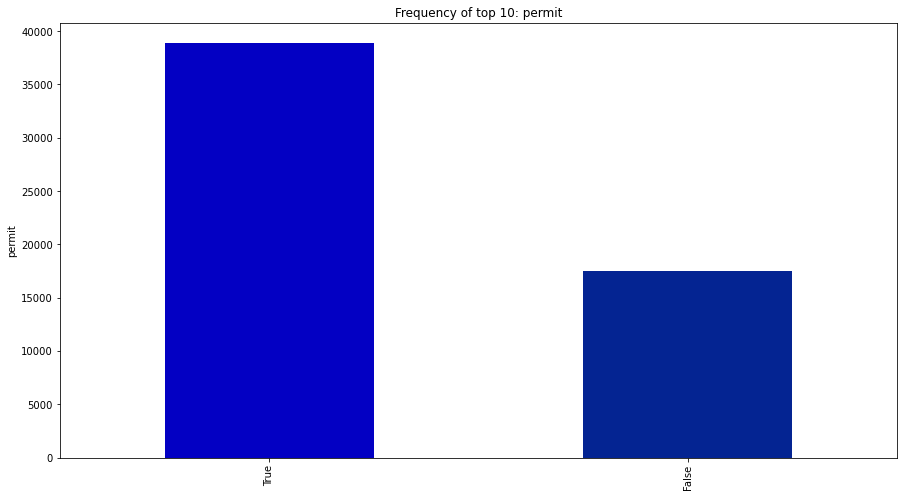

In [43]:
colInfo(df_train.permit)

We can impute the 5% missing data, but otherwise this is a highly viable column

### construction_year

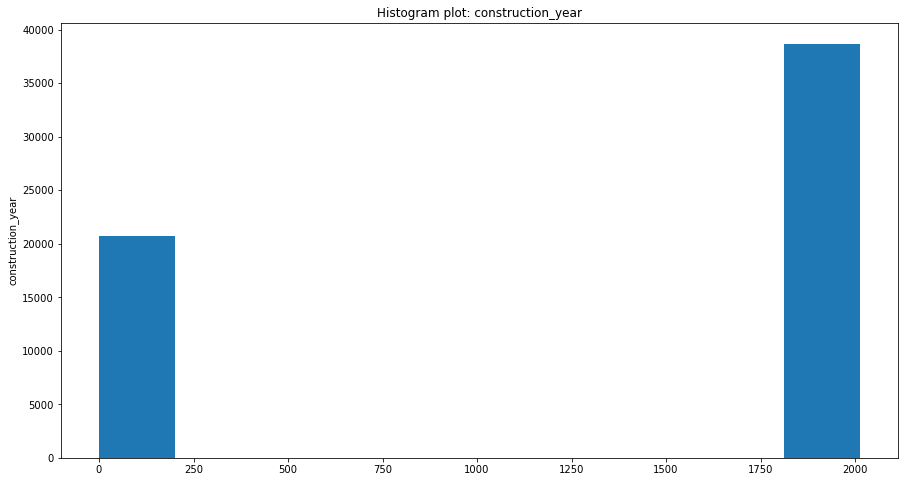

In [44]:
colInfo(df_train.construction_year)

Per the data 34.8% of the sites were built in the year 0 AD. This is a clear indicator of 0 being used as a marker for missing data. Lets look at the column some more ignore the zeroes.

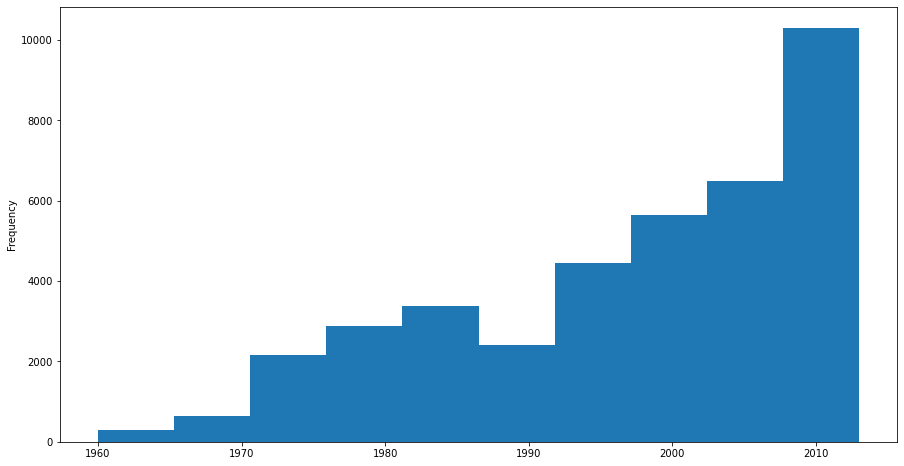

In [71]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = df_train[df_train.construction_year>0].construction_year.plot(kind='hist')
fig.savefig('images/Construction_year.jpg',bbox_inches="tight")

In [46]:
df_train.construction_year.median()

1986.0

In [47]:
df_train[df_train.construction_year>0].construction_year.median()

2000.0

In [48]:
for year in [1960, 1970, 1980, 1990, 2000, 2010]:
    print('-'*64)
    #subset by decade
    sub = df_train[(df_train.construction_year > year) &
                   (df_train.construction_year < year+10)]
    print(f'Constructed between {year} and {year+10}: Total count {sub.shape[0]}')
    print(sub.status_group.value_counts(normalize=True))

----------------------------------------------------------------
Constructed between 1960 and 1970: Total count 436
non functional             0.614679
functional                 0.302752
functional needs repair    0.082569
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1970 and 1980: Total count 3995
non functional             0.589487
functional                 0.327159
functional needs repair    0.083354
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1980 and 1990: Total count 4767
non functional             0.512272
functional                 0.411580
functional needs repair    0.076149
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1990 and 2000: Total count 6724
functional                 0.546252
non functional             0.385485
functional needs repair    0.068

The independent variable statistics for homes with a construction year of zero are most similar to 1990-2000s.\
Coincidentally, the median value of construction year for homes is 2000 when you account for the erroneously recorded years. We can impute the zero values and use this column.

### Extraction_type, Extraction_type_group, Extraction_type_group_class

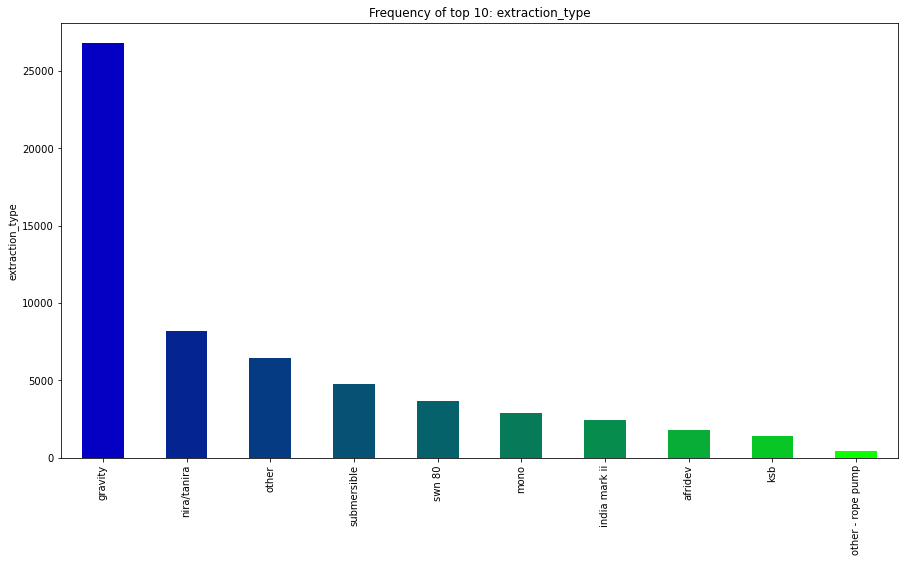

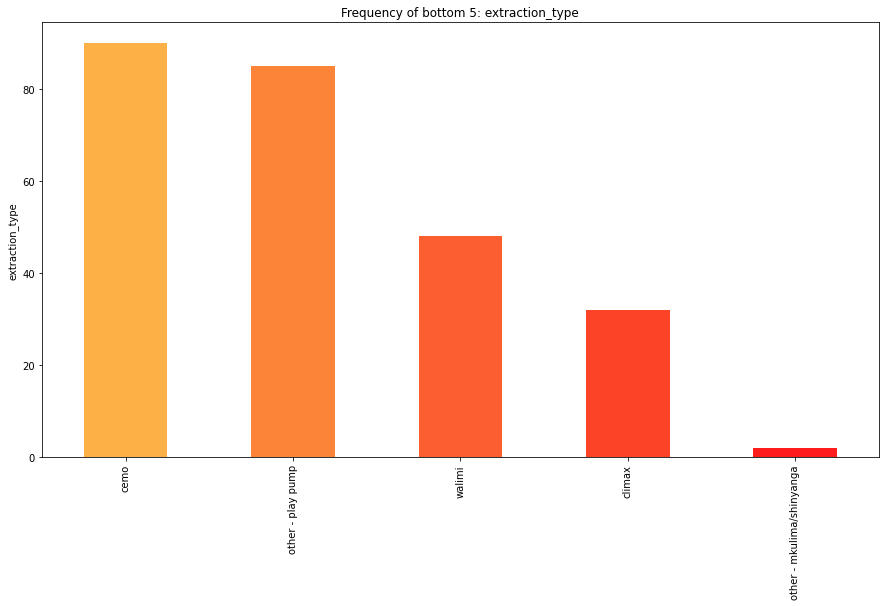

In [49]:
colInfo(df_train.extraction_type)

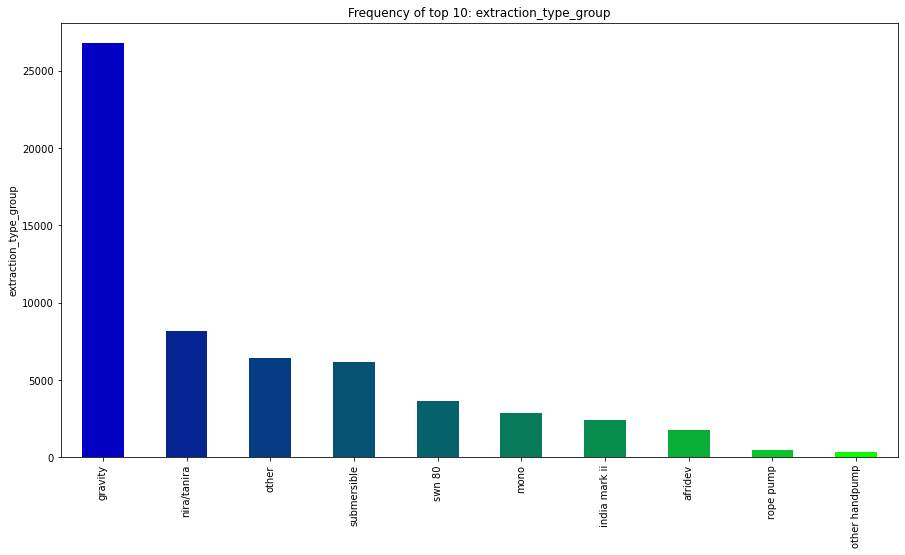

In [50]:
colInfo(df_train.extraction_type_group)

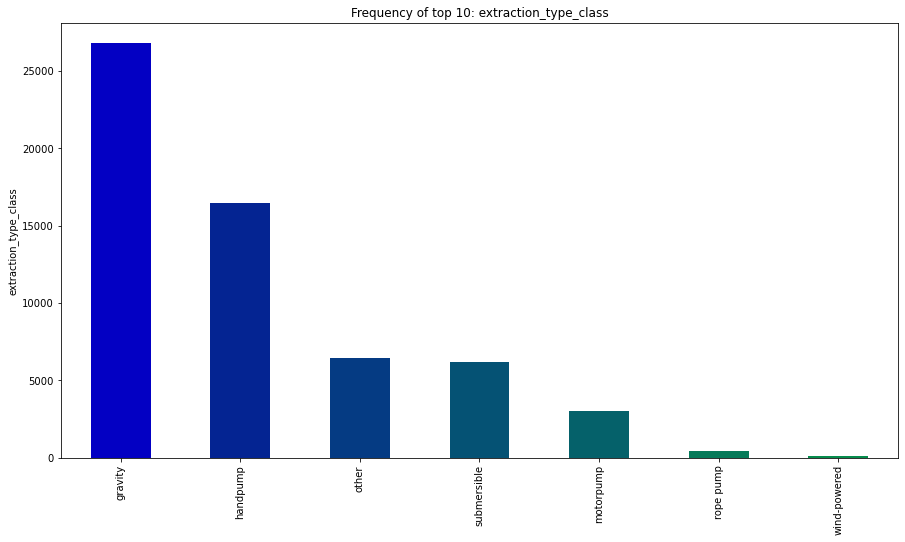

In [51]:
colInfo(df_train.extraction_type_class)

These 3 columns are almost identical. With each successive column the data is binned to a smaller number of unique values. I prefer the smallest of these subgroups (extraction_type_class), in part because it has fewer unique values but also, the data is better spread out.

### Management and Management Group

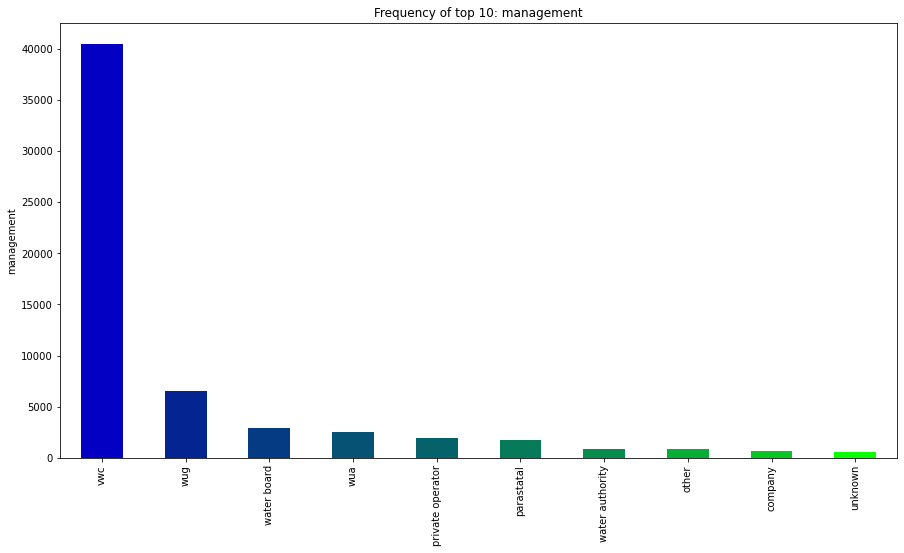

In [52]:
colInfo(df_train.management)

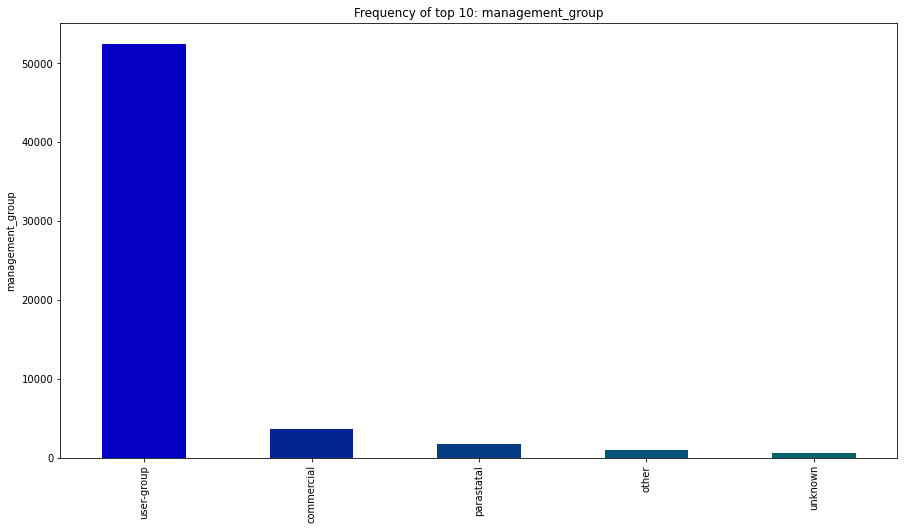

In [53]:
colInfo(df_train.management_group)

Again we have binned version of one column as a separate column. Both of these are pretty skewed, but former is better. 
Might try variations of the model using this column and without.

### Payment and Payment Group

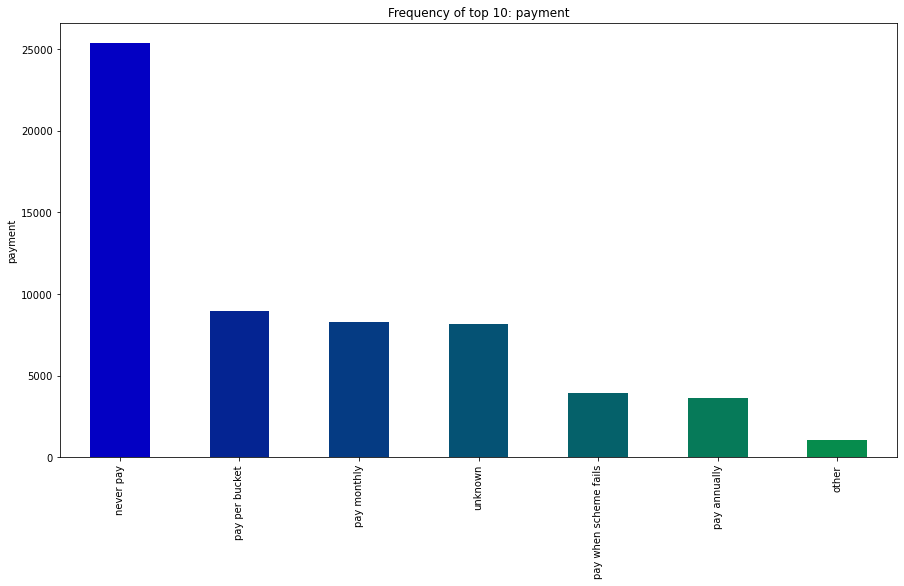

In [54]:
colInfo(df_train.payment)

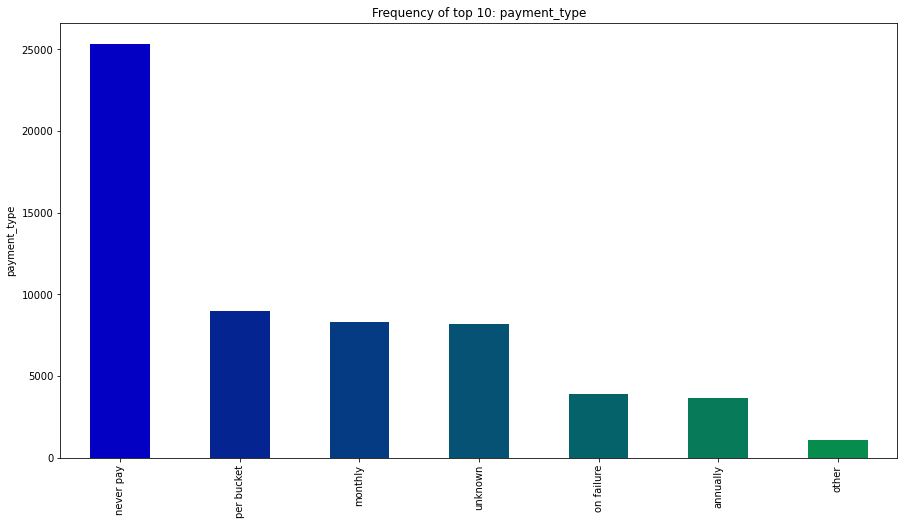

In [55]:
colInfo(df_train.payment_type)

These 2 columns are exactly identical. Drop one or the other.

### Water Quality and Quality Group

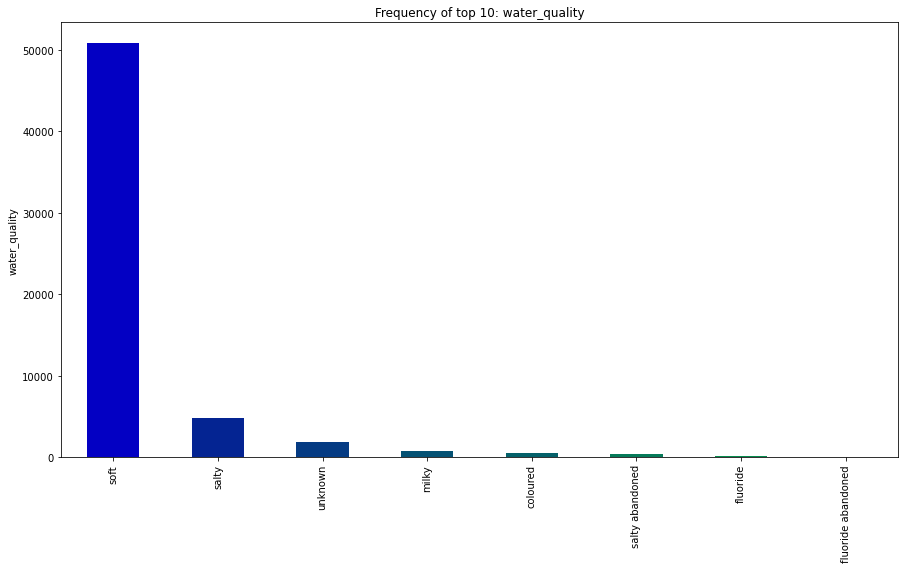

In [56]:
colInfo(df_train.water_quality)

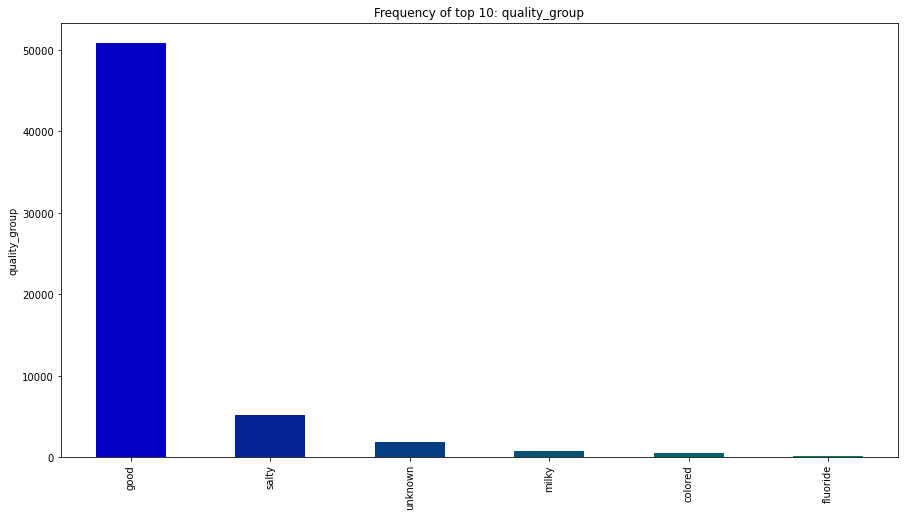

In [57]:
colInfo(df_train.quality_group)

The quality_group column bins 'Salty abandoned' and 'Salty', 'fluoride' and 'fluoride abandoned' from the first column

Again this is a heavily skewed dataset. Recommend try modeling including and not including this column.

### Quantity and Quantity_group

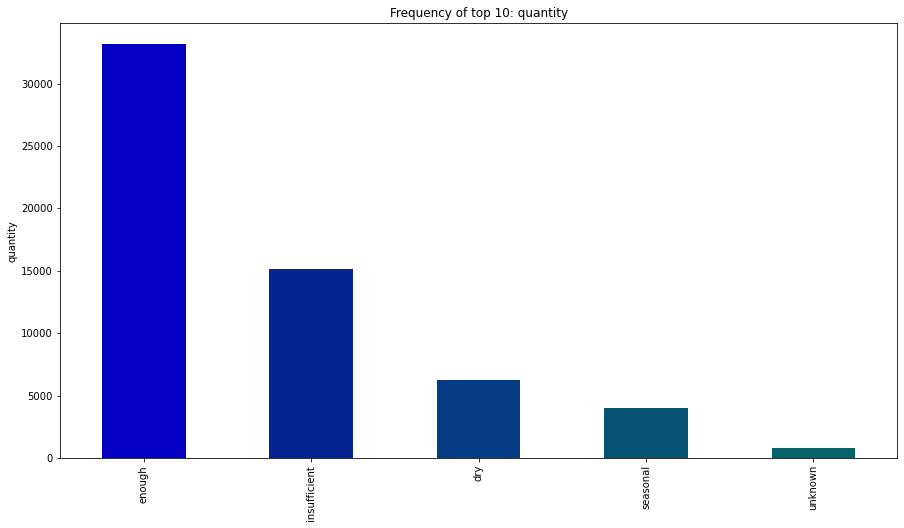

In [58]:
colInfo(df_train.quantity)

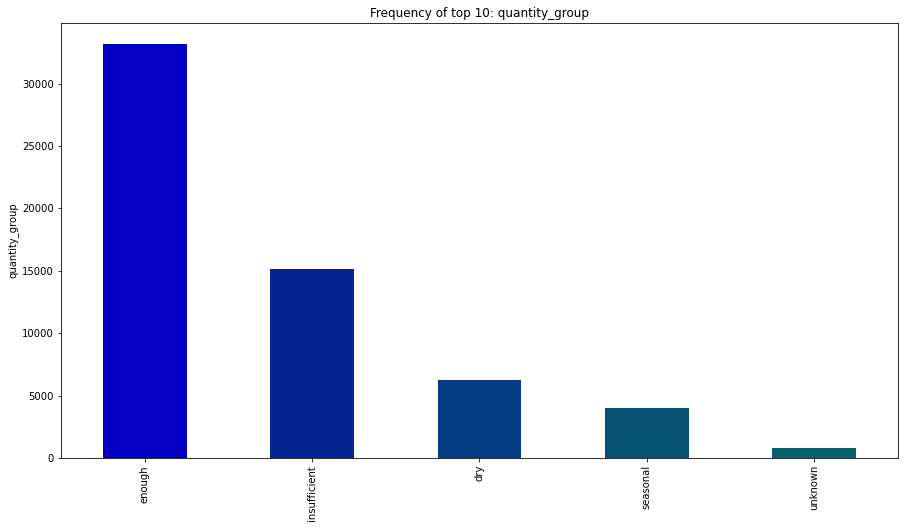

In [59]:
colInfo(df_train.quantity_group)

Exactly the same. Drop one column or the other.

### Source and Source_Type

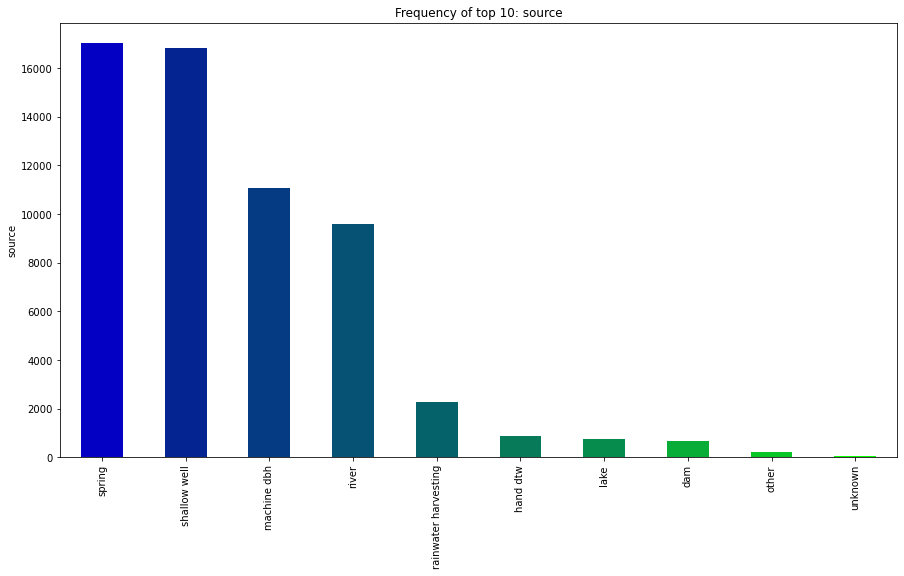

In [60]:
colInfo(df_train.source)

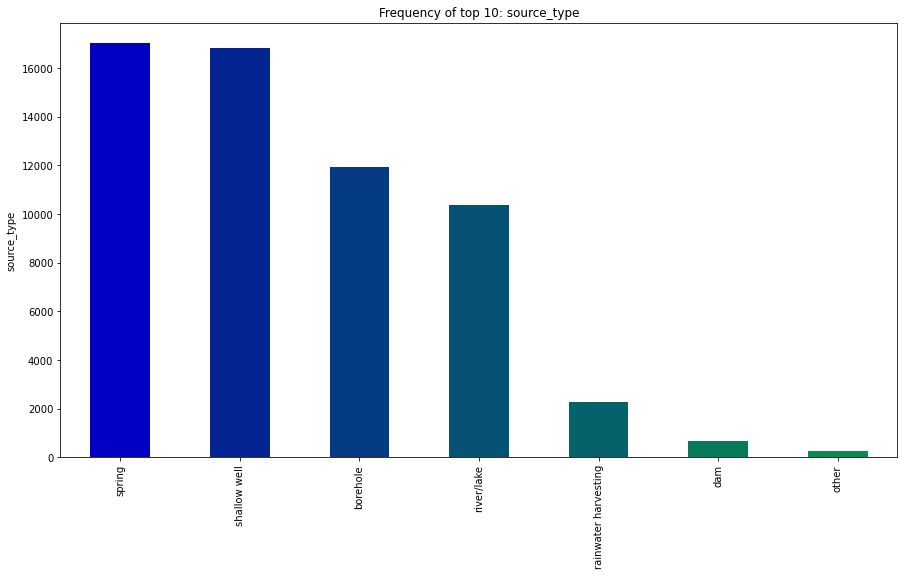

In [61]:
colInfo(df_train.source_type)

Again the second column is a binned variation of the first column. Consider trying both as predictors, but not simultaneously.

### Source Class

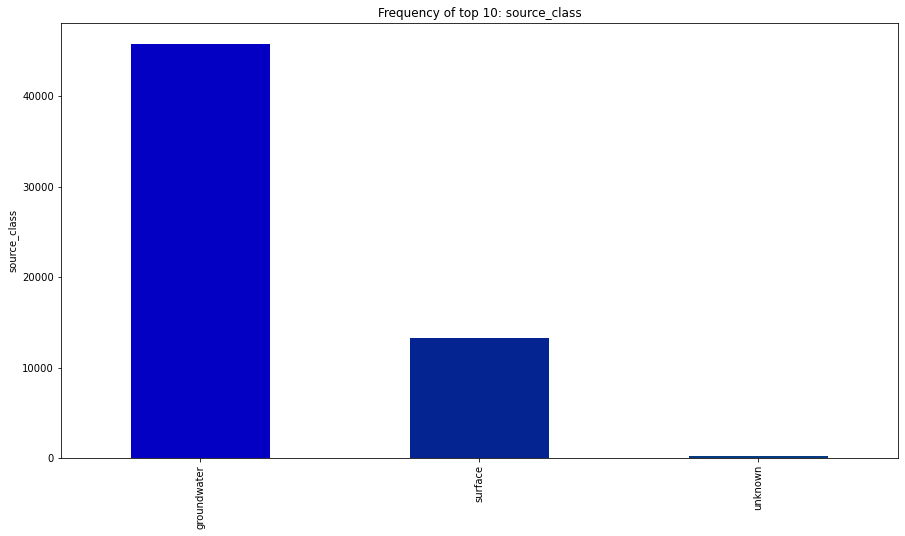

In [62]:
colInfo(df_train.source_class)

We can impute the less than 0.5% of missing data to get a binary value column that can be very viable as a predictor.

### waterpoint_type and waterpoint_type_group

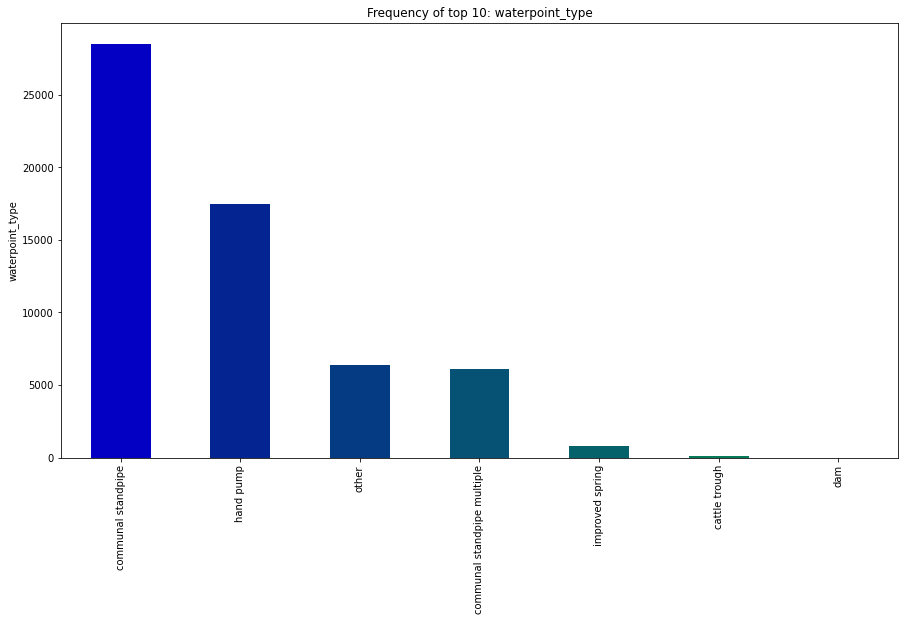

In [63]:
colInfo(df_train.waterpoint_type)

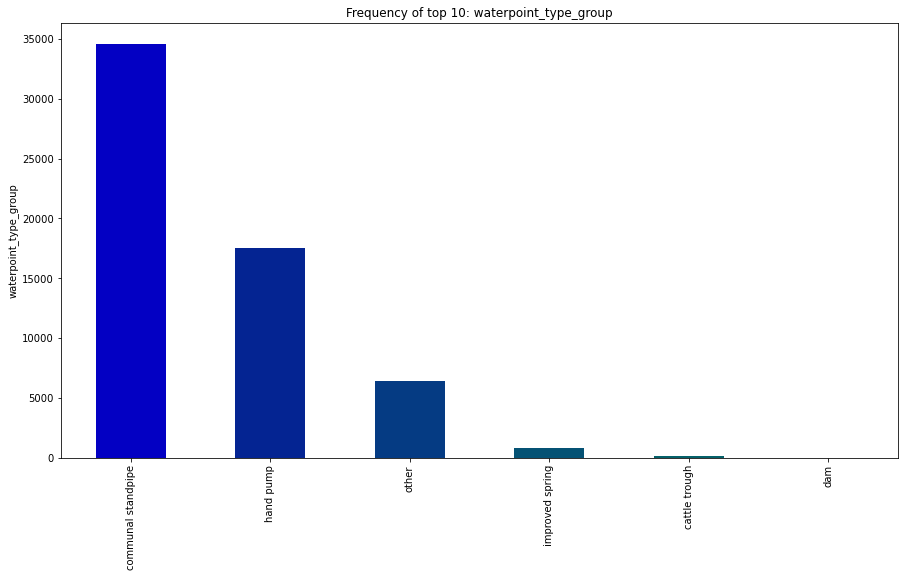

In [64]:
colInfo(df_train.waterpoint_type_group)

The second column combines 'communal standpipe' and 'communal standpipe multiple' as just 'communal standpipe'
Prefer the second for the fewer unique values and better spread of data.

# Conclusion

That concludes our exploratory analysis of the datasets independent variables. To summarize, I think the following columns hold promise. Note, as mentioned in the detailed analysis above, some of these columns have strong corelations with each other and should be used judiciously.

Numerical:
>- construction_year
>- latitude
>- longitude

Categorical:
>- basin
>- region
>- region code
>- district code
>- public_meeting
>- scheme_management
>- permit
>- source_class
>- extraction_type_class
>- management
>- payment
>- water_quality
>- quality_group
>- quantity
>- quantity_group
>- source_type
>- waterpoint_type
>- waterpoint_type_group